# Functional Encryption - Classification and information leakage

We have seen in Part 4 that reducing the output size could help reducing the collateral accuracy. We will keep it at 4 for the moment to avoid any mesurable accuracy drop on the main task. We now present a technique to try to defeat collateral learning which is based on **sabotaging** the expected adversary. The intuition is that instead of training an adversary that we expect to see and update the quadratic part according it its loss, we will update the weights in the opposite direction. All the adversaries used during training are therefore _simulated_ adversaries.

We keep the same network structure as before but now try to do a single optimisation step by improving a single loss which contains both the main objective and the opposite of the collateral objective. We introduce $\alpha$ to control the intensity of the sabotage.

More formally, what we want to do is to optimize the following problem:
$ \min_Q [ \min_C l_C(Q, C) - \alpha \min_F l_F(Q, F) ] $


The game is in 3 epoch time:
 - The normal phase where both tasks learn and strenghten before the joint optimisation:
  - `Optimize: Q + C`
  - `Optimize: Freezed(Q) + F`
 - The phase with the joint optimisation, where C and F are updated depending on the Q variations and Q is optimised to reduce the loss `C - alpha * F`:
  - `Optimize: Freezed(Q) + C`
  - `Optimize: Freezed(Q) + F`
  - `Optimize : Q + [Freezed(C) - alpha * Freezed(F)]`
 - The recovery part, where both tasks recover from the perturbation, `Q` won't change now:
  - `Optimize: Freezed(Q) + C`
  - `Optimize: Freezed(Q) + F`

# 5. Joint optimisation


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [13]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import learn
from learn import show_results
# We now import from the collateral module
from learn import collateral

Let's define the model with the describes architecture. Basically you have 3 blocs: 1 quadratic and 2 CNN.

In [15]:
PRIVATE_OUTPUT_SIZE = 4
N_CHARS = 10
N_FONTS = 2

class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.sabotage_epochs = 10
        self.recovering_epochs = 10
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 300

class CollateralNet(nn.Module):
    def __init__(self):
        super(CollateralNet, self).__init__()
        self.proj1 = nn.Linear(784, 40)
        self.diag1 = nn.Linear(40, PRIVATE_OUTPUT_SIZE, bias=False)

        # --- FFN for characters
        self.lin1 = nn.Linear(PRIVATE_OUTPUT_SIZE, 32)
        self.lin2 = nn.Linear(32, N_CHARS)

        # --- FFN for families
        self.lin3 = nn.Linear(PRIVATE_OUTPUT_SIZE, 32)
        self.lin4 = nn.Linear(32, N_FONTS)

    def quad(self, x):
        # --- Quadratic
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x

    def char_net(self, x):
        # --- FFN
        x = F.relu(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

    def font_net(self, x):
        # --- FFN
        x = F.relu(x)
        x = F.relu(self.lin3(x))
        x = self.lin4(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.char_net(x)
        return F.log_softmax(x, dim=1)

    def forward_font(self, x):
        x = self.quad(x)
        x = self.font_net(x)
        return F.log_softmax(x, dim=1)
    
    # We add the ability to freeze some layers to ensure that the collateral task does
    # not modify the quadratic net
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.lin1, self.lin2]
        elif net == 'font':
            layers = [self.lin3, self.lin4]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params

    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False

    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True
    
    

## 5.1 Introducing sabotage

This function orchestrate the sabotage in three phases like explained in introduction. Note that we change the optimiser because Adam causes some diverging results for alpha > 0.5, so we use the classic SGD instead which also performs very well. (_Note: the learning rate could explain this_)

In [16]:
def build_resistance(model, alpha=0):
    """
    Perform a dual learning phase with sabotage
    """
    args = Parser()
    
    train_loader, test_loader = collateral.get_data_loaders(args)

    # optimizer = optim.Adam(model.parameters(), lr=args.lr)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.epochs + args.sabotage_epochs + args.recovering_epochs + 1):
        initial_phase = epoch <= args.epochs
        if initial_phase:
            print("(initial phase)")
        perturbate = epoch > args.epochs and epoch <= args.epochs + args.sabotage_epochs
        if perturbate:
            print("(perturbate)")
        recover = epoch > args.epochs + args.sabotage_epochs
        if recover:
            print("(recover)")
        collateral.train(
            args, model, train_loader, optimizer, epoch, alpha, 
            initial_phase, perturbate, recover, False
        )
        test_perf_char, test_perf_font = collateral.test(args, model, test_loader, False)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font

In [17]:
results = {}

In [60]:
alphas = [0, 0.6, 1, 1.3, 1.5, 1.7, 2, 3]  # feel free to drop some values to get faster computation
for alpha in alphas:
    print('\n -----', alpha)
    model = CollateralNet()
    test_perfs_char_perturbate, test_perfs_font_perturbate = build_resistance(model, alpha)
    results[f"Main task with alpha {alpha}"] = test_perfs_char_perturbate
    results[f"Collateral task with alpha {alpha}"] = test_perfs_font_perturbate


 ----- 0
Training set 60000 items
Testing set  10000 items
(initial phase)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 2.324175 Loss Font: 0.687838
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 1.607024 Loss Font: 0.709362
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.811807 Loss Font: 0.644877
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.410369 Loss Font: 0.667272

Test set: Accuracy Char : 8726/10000 (87.26%)
          Accuracy Font : 5876/10000 (58.76%)
(initial phase)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.381176 Loss Font: 0.729502
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.320968 Loss Font: 0.680739
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.182323 Loss Font: 0.678145
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.187852 Loss Font: 0.724124

Test set: Accuracy Char : 9475/10000 (94.75%)
          Accuracy Font : 6144/10000 (61.44%)
(initial phase)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.161582 Loss Font: 0.638084
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 

Train Epoch: 21 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.515450
Train Epoch: 21 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.544754
Train Epoch: 21 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.494518

Test set: Accuracy Char : 9872/10000 (98.72%)
          Accuracy Font : 7300/10000 (73.00%)
(recover)
Train Epoch: 22 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.499783
Train Epoch: 22 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.493262
Train Epoch: 22 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.455137
Train Epoch: 22 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.436813

Test set: Accuracy Char : 9868/10000 (98.68%)
          Accuracy Font : 7301/10000 (73.01%)
(recover)
Train Epoch: 23 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.410789
Train Epoch: 23 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.475456
Train Epoch: 23 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.584345
Train Epoch: 23 [57600/60000 (96%)]	Loss Cha

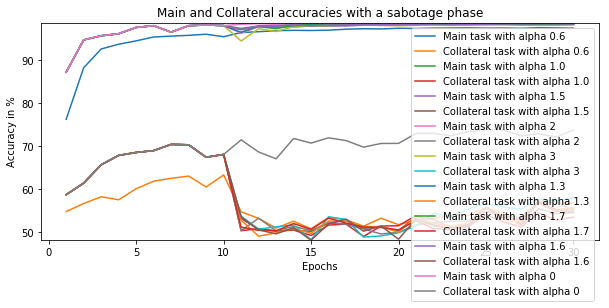

In [61]:
show_results(results, title="Main and Collateral accuracies with a sabotage phase")

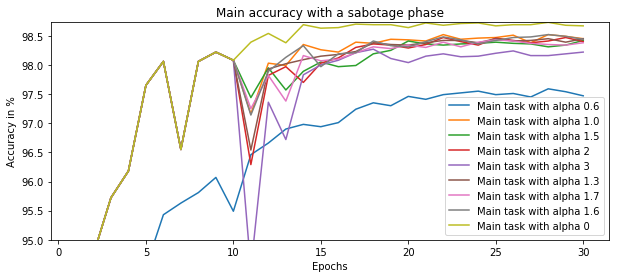

In [62]:
main_results = {k:v for k, v in results.items() if 'Main' in k}
show_results(main_results, title="Main accuracy with a sabotage phase", ymin=95)

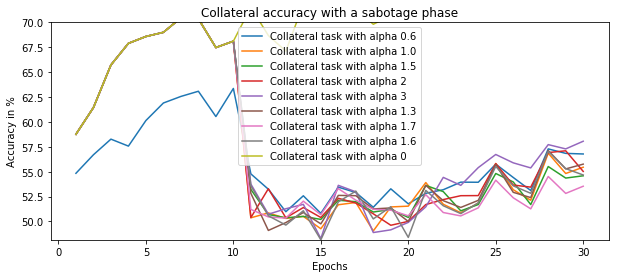

In [63]:
collateral_results = {k:v for k, v in results.items() if 'Collateral' in k}
show_results(collateral_results, title="Collateral accuracy with a sabotage phase", ymax=70)

We only distinguish the difference between phase 1 and 2, when we start perturbing Q against the collateral task; the recovering part is not clearly visible even if we observe that it helps recovering a bit of accuracy in the most perturbed settings.
What we observe is that we achieve a far better trade-off than in Part 9. We assume that the training advantage of the tasks is similar to the one in Part 9, as we have given 30 epochs to improve, including 10 epochs for recovering.

## 5.2 Comparison of the $\alpha$ values

We report the results for a better visualisation of the trade-off that we have now:

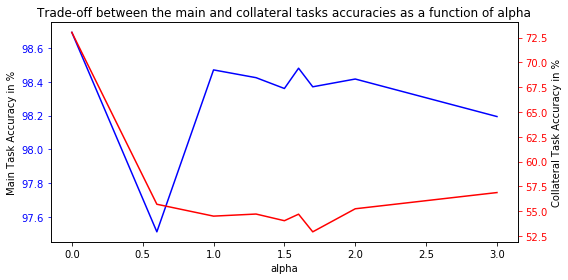

In [64]:
import matplotlib.pyplot as plt
import numpy as np

main_scores = []
collateral_scores = []
alpha_values = []
for k, v in main_results.items():
    main_scores.append(np.mean(v[-5:]))
    alpha_values.append(float(k.split(' ')[-1]))
for k, v in collateral_results.items():
    collateral_scores.append(np.mean(v[-5:]))
    
main_scores = [x for _,x in sorted(zip(alpha_values, main_scores))]
collateral_scores = [x for _,x in sorted(zip(alpha_values, collateral_scores))]
alpha_values = sorted(alpha_values)

fig, ax1 = plt.subplots(figsize=(8, 4))

ax1.plot(alpha_values, main_scores, 'b', label='Main Task accuracy')
ax1.set_xlabel('alpha')
ax1.set_ylabel('Main Task Accuracy in %')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(alpha_values, collateral_scores, 'r', label='Collateral Task accuracy')
ax2.set_ylabel('Collateral Task Accuracy in %')
ax2.tick_params('y', colors='r')

plt.title('Trade-off between the main and collateral tasks accuracies as a function of alpha')
fig.tight_layout()
plt.show()

The value $\alpha = 1.7$ seems to offer the best trade-off, so we will keep it for the next experiments.

## Conclusion

This technique of joint optimisation gives us very interesting trade-offs, as we get accuracy as high as 98.4% while with the small collateral network we only have 53% accuracy! 

The next questions we can try to solve is to put other models on the private output especially to test more powerful collateral neural networks to try increasing the ability of the collateral task to recover some information.

You can find in Part 5 bis extended computations to have more reliable results, you'll find there fancy figures (at the bottom) but this is it!